# Compute mutual information and expression shift matrix

In [21]:
import numpy as np
import pandas as pd
from numba import njit

import scipy
import matplotlib.pyplot as plt
import regseq2

regseq2.viz.matplotlib_style()

from glob import glob
import itertools

After processing the data, we compute information footprints and expression shifts to summarize the outcomes of the experiments. First, we have to identify the promoter variant for each barcode that we counted in the expression experiments.

## Combine mapped promoters and barcodes into dataframe

In [26]:
df_map_example = pd.read_csv('../data/barcode_map/examples/example_map.csv')
df_map_example = df_map_example.groupby("barcode").filter(lambda group: len(group) == 1)
df_map_example = df_map_example[(df_map_example['count'] > 2) & (df_map_example['promoter'] != '*')].reset_index(drop=True)
df_map_example.head()

,promoter_variant,barcode,count,promoter


## Import wild type sequences

We also need the wild type sequences for each promoter to identify which bases are mutated in each promoter variant. 

In [23]:
df_wt = pd.read_csv("../data/metadata/wt_sequences.csv")[['promoter_seq', 'promoter']]
wt_dict = dict(zip(df_wt['promoter'].values, df_wt['promoter_seq'].values))
df_wt

,promoter_seq,promoter
0,TTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTT...,rspAp
1,TCCACATTGATTATTTGCACGGCGTCACACTTTGCTATGCCATAGC...,araBp
2,GTGTTGCACCTCCCCAGAGAGCGGCGGATAATGCTGCGAAAAGAAG...,znuCp
3,CCAGTTTCATCATTCCATTTTATTTTGCGAGCGAGCGCACACTTGT...,xylAp
4,AATTGCGCAACAAAAGTAAGATCTCGGTCATAAATCAAGAAATAAA...,xylFp
...,...,...
114,TGGTGCTGGTTATCAGCACTGAAGGCGACACCGACGTGAAGCACTA...,ygeY_predicted
115,CGCTGGACGAAATCCGCGCCCTGCCTGCAGTACAGAAAGCTAACGC...,hyuA_predicted
116,TCGGACATGTTTGAAGAGATGAAATTTGCCTTCTTTAAACATCGCG...,ygfM_xdhD_predicted
117,AGTGCCAGTTTTTGCGAGGAAGGGGAGTTAGAGACAGGAATTGCGG...,ygfS_ygfT_predicted


## Import barcode counts and compute mutual information footprints

With the wild type sequences in hand, we can import the barcode counts both for RNA sequencing and DNA sequencing. We match the barcodes from each file, and then compare to the mapping file. Finally we compute mutual information per position and plot as barplot. We also apply a gaussian kernel to smooth the footprints to make it easier to identify peaks in the footprints.

In [24]:
# import DNA counts
df_DNA_example = pd.read_csv('../data/extracted_barcodes/examples/DNA_collapsed.txt')

# import RNA counts
df_RNA_example = pd.read_csv('../data/extracted_barcodes/examples/RNA_collapsed.txt')

@njit
def compare_string_bytes(s1, s2):
    # Ensure both strings are of equal length.
    n = len(s1)
    if n != len(s2):
        raise ValueError("Strings must have the same length")
    result = np.empty(n, dtype=np.int64)
    for i in range(n):
        result[i] = 1 if s1[i] == s2[i] else 0
    return result

# log function that can handle 0 * log(0)
def clog(x, y, z):
    if x == 0 or y == 0 or z==0:
        return 0
    else:
        return x * np.log2(x / (y * z))

# combine barcode counts
# if a barcode is not found in one of the datasets, assign zero counts
df_counts = df_DNA_example.merge(df_RNA_example, on="barcode", how='outer').fillna(0)
# identify promoter variants for each barcode, discard barcodes without match
df_counts = df_counts.merge(df_map_example, on="barcode", how='inner')

# find where the mutations are
wt_seq = wt_dict['tisBp']
is_wt = np.vstack([np.array(compare_string_bytes(wt_seq.encode("ascii"), x.encode("ascii"))) for x in df_counts['promoter_variant'].values])

# compute joint probability distribution
p = np.zeros([160, 2, 2])
p [:, :, 0] = np.matmul(is_wt.T, np.vstack([df_counts['ct_0'].values, df_counts['ct_1'].values]).T)
p [:, :, 1] = np.matmul((1-is_wt).T, np.vstack([df_counts['ct_0'].values, df_counts['ct_1'].values]).T)
p = p / (np.sum(df_counts['ct_0'].values) + np.sum(df_counts['ct_1'].values))

# compute mutual information per position
mut_info = [sum([clog(p[i, j, k], np.sum(p[i, :, k]), np.sum(p[i, j, :])) for j in range(2) for k in range(2)]) for i in range(160)]

fig, ax = plt.subplots(figsize=(7, 2))

# 
y = scipy.ndimage.gaussian_filter1d(mut_info, 2)
ax.bar(np.arange(-115, 45), y, width=1)

ax.set_xlabel("position relative to TSS")
ax.set_ylabel("smoothed mutual\n information [bits]")


ValueError: need at least one array to concatenate

## Compute expression shifts

Another summary statistic we use is the one of expression shift matrices. Such a matrix shows how much relative expression (RNA counts relative to DNA counts) is changed on average for every single point mutation in the sequence, compared to the average measured expression across all sequences. 

In [ ]:
# Precompute the mapping outside the function
DNA_MAPPING = np.zeros(256, dtype=np.uint8)
DNA_MAPPING[ord('A')] = 0
DNA_MAPPING[ord('C')] = 1
DNA_MAPPING[ord('G')] = 2
DNA_MAPPING[ord('T')] = 3

# function to transform letters to integers
def dna_to_int(seq, mapping=DNA_MAPPING):
    # Convert the sequence to a numpy array of its ASCII codes.
    arr = np.frombuffer(seq.encode('ascii'), dtype=np.uint8)
    return mapping[arr]

# transform entire sequence to array of integer
def batch_dna_to_int(sequences, mapping=DNA_MAPPING):
    # Assume all sequences are the same length.
    n = len(sequences[0])
    # Create a 2D array of shape (num_sequences, n)
    seq_arr = np.empty((len(sequences), n), dtype=np.uint8)
    for i, seq in enumerate(sequences):
        seq_arr[i, :] = np.frombuffer(seq.encode('ascii'), dtype=np.uint8)
    return mapping[seq_arr]


# compute expression shifts and accumulate to 
@njit
def accumulate_shifts(int_seq, is_mut, exp_diff, ex_shift_arr, norm_arr):
    num_variants, seq_len = int_seq.shape
    for i in range(num_variants):
        for j in range(seq_len):
            base = int_seq[i, j]
            ex_shift_arr[j, base] += exp_diff[i] * is_mut[i, j]
            norm_arr[j, base] +=  is_mut[i, j]


positions = list(itertools.product(range(-115, 45), range(1, 5)))




is_mut = 1 - np.vstack([np.array(compare_string_bytes(wt_seq.encode("ascii"), x.encode("ascii"))) for x in df_counts['promoter_variant'].values])
int_seq = batch_dna_to_int(df_counts['promoter_variant'].values)

# compute relative counts and difference to mean
relative_counts = (df_counts['ct_1'].values + 1) / (df_counts['ct_0'].values + 1)
mean_rel_counts = np.mean(relative_counts)
exp_diff = relative_counts - mean_rel_counts

# initialize expression shift array
norm_arr = np.zeros((160, 4))
ex_shift_arr = np.zeros((160, 4))

# fill array
accumulate_shifts(int_seq, is_mut, exp_diff, ex_shift_arr, norm_arr)
ex_shift_arr = ex_shift_arr / norm_arr
ex_shift_arr = np.nan_to_num(ex_shift_arr)

/var/folders/67/2rd1gct91876bvjs_7ny9rcw0000gn/T/ipykernel_47164/908580054.py:55: RuntimeWarning: invalid value encountered in divide
  ex_shift_arr = ex_shift_arr / norm_arr


In [ ]:
ex_shift_arr

array([[-5.13570643e-01,  0.00000000e+00,  1.14059602e+00,
        -3.74240837e-01],
       [-3.96903976e-01,  1.07461103e-01,  0.00000000e+00,
         9.30873802e-01],
       [-2.63570643e-01,  0.00000000e+00, -1.30237309e-01,
        -6.66348421e-01],
       [ 0.00000000e+00,  3.19762691e-01,  2.41984913e-01,
        -8.80237309e-01],
       [ 0.00000000e+00, -4.92737309e-01, -9.89761119e-01,
        -1.35706428e-02],
       [-1.80237309e-01, -8.46038175e-01,  9.44762691e-01,
         0.00000000e+00],
       [-5.13570643e-01,  9.75404683e-02,  6.10671781e-01,
         0.00000000e+00],
       [-1.01357064e+00,  1.26429357e-01, -2.21903976e-01,
         0.00000000e+00],
       [ 6.88810310e-01,  0.00000000e+00,  3.04611175e-01,
         1.70071507e+00],
       [-7.63570643e-01,  1.20411643e+00,  0.00000000e+00,
         3.91984913e-01],
       [-4.50607680e-01, -8.54840484e-01,  0.00000000e+00,
        -3.65157944e-01],
       [-3.63570643e-01,  0.00000000e+00, -8.60792865e-01,
      

(<Figure size 320x80 with 1 Axes>, <Axes: >)

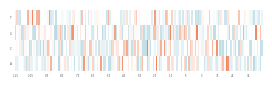

In [ ]:
regseq2.viz.plot_exshift(ex_shift_arr.T, xscale=10)